In [9]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
            os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
#        Define the custom dataset class
#A data loader is a crucial component for managing your dataset.
#here the data loader would load images (or other data types) of poles with and without defects,
#and their corresponding labels (defected or not defected).
#Since it is custom, we have had to:
#Read data from a specific directory structure or file format.
#Apply preprocessing steps (resizing, normalization, augmentation).
#Shuffle and batch your data for training and testing.

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
class PoleDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))
        self.labels = sorted(os.listdir(labels_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        label_path = os.path.join(self.labels_dir, self.labels[idx])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Load label (assumed to be in YOLO txt format)
        with open(label_path, 'r') as f:
            label = f.readlines()

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert labels to tensor (dummy for now, adjust based on your txt structure)
        label_tensor = torch.tensor([float(x) for x in label[0].split()])

        return image, label_tensor # Return the image and corresponding labels



# Paths to dataset folders
train_images_dir = "/kaggle/input/pole-defects-1/Pole_Detection.v2i.yolov5pytorch/train/images"
train_labels_dir = "/kaggle/input/pole-defects-1/Pole_Detection.v2i.yolov5pytorch/train/labels"

val_images_dir = "/kaggle/input/pole-defects-1/Pole_Detection.v2i.yolov5pytorch/valid/images"
val_labels_dir = "/kaggle/input/pole-defects-1/Pole_Detection.v2i.yolov5pytorch/valid/labels"

test_images_dir = "/kaggle/input/pole-defects-1/Pole_Detection.v2i.yolov5pytorch/test/images"
test_labels_dir = "/kaggle/input/pole-defects-1/Pole_Detection.v2i.yolov5pytorch/test/labels"


# Image transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = PoleDataset(train_images_dir, train_labels_dir, transform=transform)
val_dataset = PoleDataset(val_images_dir, val_labels_dir, transform=transform)
test_dataset = PoleDataset(test_images_dir, test_labels_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
 


In [11]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
#cnn work on this
class PoleDefectClassifier(nn.Module):
    def __init__(self):
        super(PoleDefectClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # Adjust based on your image size
        self.fc2 = nn.Linear(128, 2)  # 2 output classes (defected or not defected)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)  # Flatten for fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Training loop
import torch.optim as optim

device = torch.device("cpu")
model = PoleDefectClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels[:, 0].long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels[:, 0].long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Step [10/28], Loss: 2.2704
Epoch [1/10], Step [20/28], Loss: 0.3917
Validation Loss: 0.8590, Validation Accuracy: 73.44%
Epoch [2/10], Step [10/28], Loss: 0.2603
Epoch [2/10], Step [20/28], Loss: 0.1960
Validation Loss: 0.3519, Validation Accuracy: 84.38%
Epoch [3/10], Step [10/28], Loss: 0.1118
Epoch [3/10], Step [20/28], Loss: 0.0843
Validation Loss: 0.3280, Validation Accuracy: 90.62%
Epoch [4/10], Step [10/28], Loss: 0.0205
Epoch [4/10], Step [20/28], Loss: 0.0408
Validation Loss: 0.3249, Validation Accuracy: 82.81%
Epoch [5/10], Step [10/28], Loss: 0.0318
Epoch [5/10], Step [20/28], Loss: 0.0227
Validation Loss: 0.4036, Validation Accuracy: 87.50%
Epoch [6/10], Step [10/28], Loss: 0.0059
Epoch [6/10], Step [20/28], Loss: 0.0034
Validation Loss: 0.4028, Validation Accuracy: 90.62%
Epoch [7/10], Step [10/28], Loss: 0.0014
Epoch [7/10], Step [20/28], Loss: 0.0019
Validation Loss: 0.4308, Validation Accuracy: 90.62%
Epoch [8/10], Step [10/28], Loss: 0.0006
Epoch [8/10], 

In [13]:
# Testing the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for images, labels in test_loader:  # Unpack only images and labels
        images, labels = images.to(device), labels[:, 0].long().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')




Test Accuracy: 90.32%


Images found in directory: ['/kaggle/input/deployment-of-detection/deployment/gettyimages-1489454271-170667a.jpg', '/kaggle/input/deployment-of-detection/deployment/pexels-tranthangnhat-17594281.jpg', '/kaggle/input/deployment-of-detection/deployment/gettyimages-903206380-170667a.jpg', '/kaggle/input/deployment-of-detection/deployment/pexels-abhiraj-mengade-1478094393-27014933.jpg', '/kaggle/input/deployment-of-detection/deployment/gettyimages-1915744881-594x594.jpg', '/kaggle/input/deployment-of-detection/deployment/pexels-kemoi-brown-1392056577-26223034.jpg', '/kaggle/input/deployment-of-detection/deployment/pexels-roman-odintsov-6585277.jpg', '/kaggle/input/deployment-of-detection/deployment/gettyimages-157337477-170667a.jpg', '/kaggle/input/deployment-of-detection/deployment/gettyimages-478849280-170667a.jpg', '/kaggle/input/deployment-of-detection/deployment/pexels-asumaani-10730096.jpg', '/kaggle/input/deployment-of-detection/deployment/gettyimages-1235032519-594x594.jpg', '/kagg

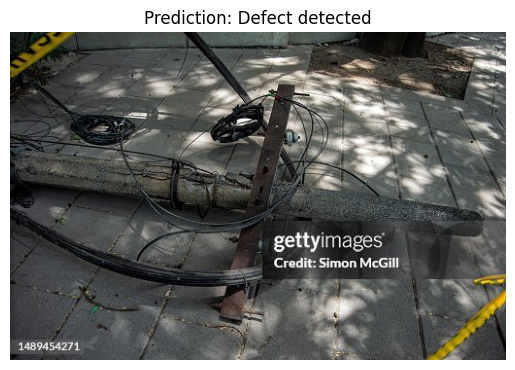

Image: /kaggle/input/deployment-of-detection/deployment/gettyimages-1489454271-170667a.jpg - Predicted label: Defect detected
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-tranthangnhat-17594281.jpg


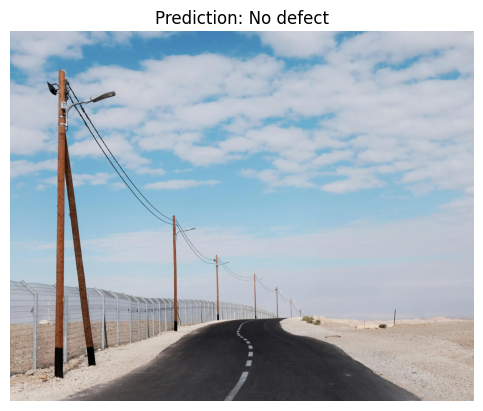

Image: /kaggle/input/deployment-of-detection/deployment/pexels-tranthangnhat-17594281.jpg - Predicted label: No defect
Processing: /kaggle/input/deployment-of-detection/deployment/gettyimages-903206380-170667a.jpg


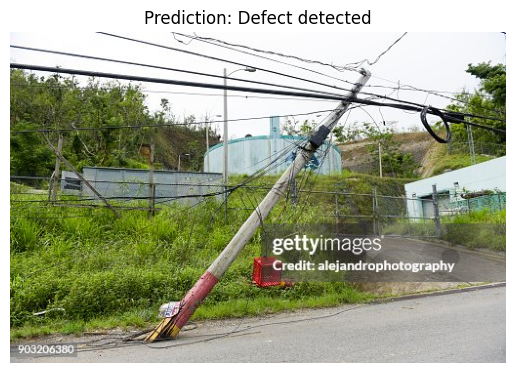

Image: /kaggle/input/deployment-of-detection/deployment/gettyimages-903206380-170667a.jpg - Predicted label: Defect detected
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-abhiraj-mengade-1478094393-27014933.jpg


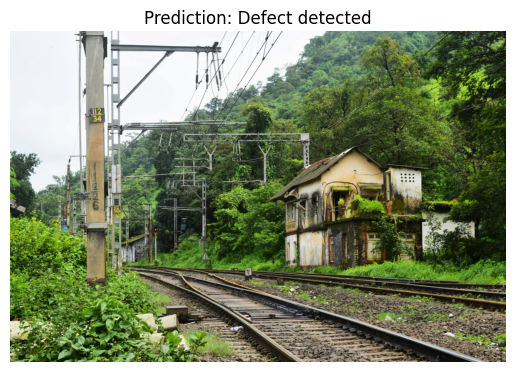

Image: /kaggle/input/deployment-of-detection/deployment/pexels-abhiraj-mengade-1478094393-27014933.jpg - Predicted label: Defect detected
Processing: /kaggle/input/deployment-of-detection/deployment/gettyimages-1915744881-594x594.jpg


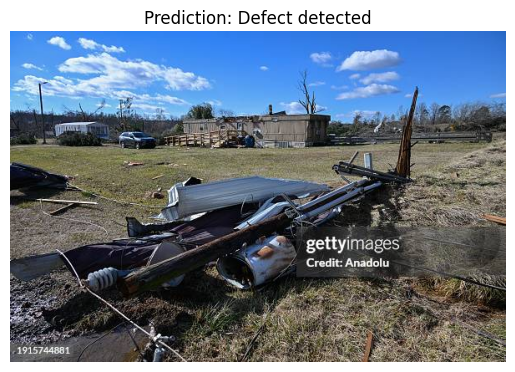

Image: /kaggle/input/deployment-of-detection/deployment/gettyimages-1915744881-594x594.jpg - Predicted label: Defect detected
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-kemoi-brown-1392056577-26223034.jpg


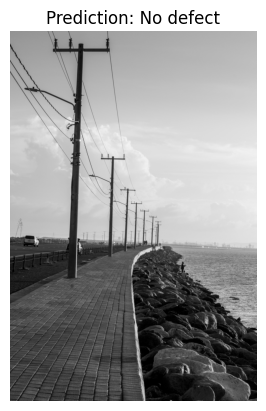

Image: /kaggle/input/deployment-of-detection/deployment/pexels-kemoi-brown-1392056577-26223034.jpg - Predicted label: No defect
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-roman-odintsov-6585277.jpg


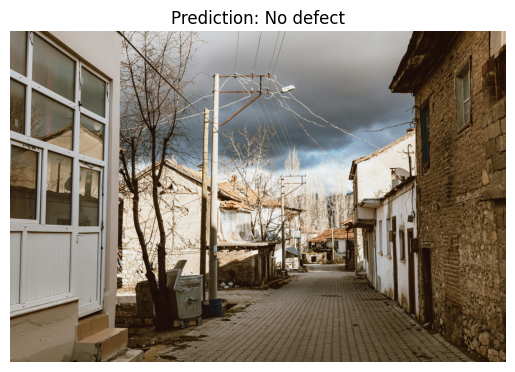

Image: /kaggle/input/deployment-of-detection/deployment/pexels-roman-odintsov-6585277.jpg - Predicted label: No defect
Processing: /kaggle/input/deployment-of-detection/deployment/gettyimages-157337477-170667a.jpg


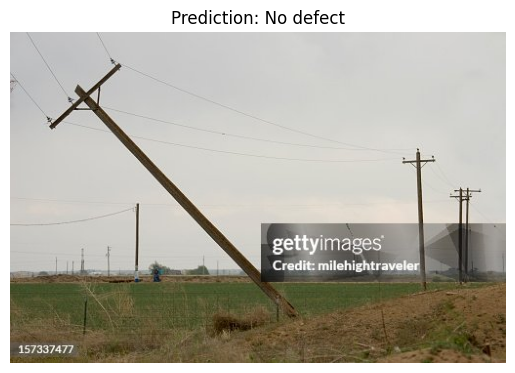

Image: /kaggle/input/deployment-of-detection/deployment/gettyimages-157337477-170667a.jpg - Predicted label: No defect
Processing: /kaggle/input/deployment-of-detection/deployment/gettyimages-478849280-170667a.jpg


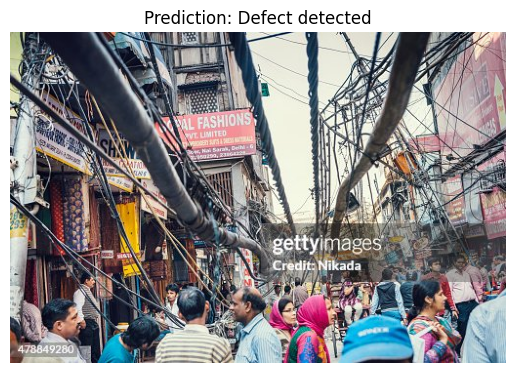

Image: /kaggle/input/deployment-of-detection/deployment/gettyimages-478849280-170667a.jpg - Predicted label: Defect detected
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-asumaani-10730096.jpg


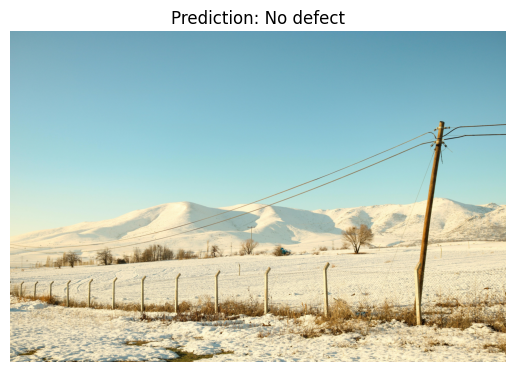

Image: /kaggle/input/deployment-of-detection/deployment/pexels-asumaani-10730096.jpg - Predicted label: No defect
Processing: /kaggle/input/deployment-of-detection/deployment/gettyimages-1235032519-594x594.jpg


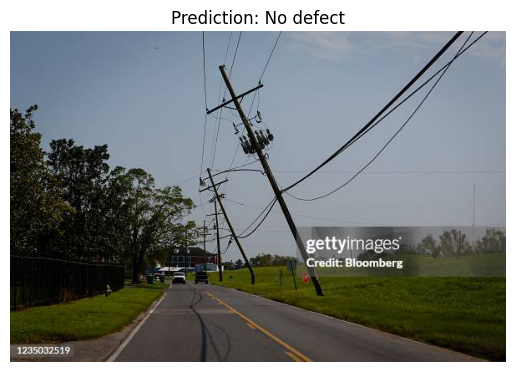

Image: /kaggle/input/deployment-of-detection/deployment/gettyimages-1235032519-594x594.jpg - Predicted label: No defect
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-alexquezada-15474761.jpg


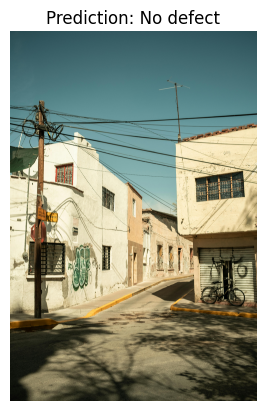

Image: /kaggle/input/deployment-of-detection/deployment/pexels-alexquezada-15474761.jpg - Predicted label: No defect
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-alteredsnaps-11973739.jpg


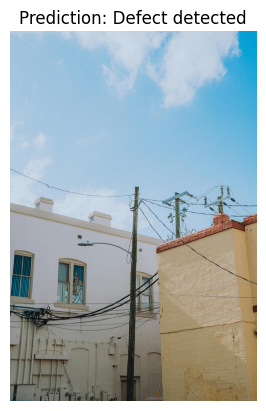

Image: /kaggle/input/deployment-of-detection/deployment/pexels-alteredsnaps-11973739.jpg - Predicted label: Defect detected
Processing: /kaggle/input/deployment-of-detection/deployment/pexels-diana-gradinaru-299521186-13337846.jpg


In [ ]:
#deployment
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Define the path to your new dataset (update with your dataset path on Kaggle)
new_images_dir = "/kaggle/input/deployment-of-detection"  # Update with your actual path

# Define a list to hold valid image paths
new_image_files = []

# Recursively search for image files in the directory and subdirectories
for root, dirs, files in os.walk(new_images_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            new_image_files.append(os.path.join(root, file))

# Check if valid images are found
print(f"Images found in directory: {new_image_files}")

# Set model to evaluation mode
model.eval()

# Define your image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loop over all images in the dataset
for img_path in new_image_files:
    print(f"Processing: {img_path}")

    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    image_transformed = transform(image).unsqueeze(0)  # Add batch dimension
    image_transformed = image_transformed.to(device)  # Move to the appropriate device (CPU/GPU)

    # Disable gradient computation for inference
    with torch.no_grad():
        # Get model predictions
        output = model(image_transformed)
        _, predicted = torch.max(output.data, 1)  # Get predicted class

    # Interpret prediction
    prediction = "No defect" if predicted.item() == 1 else "Defect detected"

    # Display the image with prediction
    plt.imshow(image)
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')  # Hide the axis
    plt.show()

    # Print prediction for each image
    print(f"Image: {img_path} - Predicted label: {prediction}")
